# Aggregator Separation and Pool Analysis

## Overview

This notebook separates **aggregators** (Jupiter, DeFlow, Phoenix, etc.) from the binary classification results and analyzes their corresponding pools/AMMs.

### Why This Notebook?

In binary classification (07a), all non-MEV classes (aggregators, wash trading, regular) were grouped into **Non-MEV (0)**. This simplified the problem but "lost" the aggregator distinction.

**Aggregators** are legitimate routers that help users find the best prices across multiple pools. They are characterized by:
- High  (>0.5, often >0.8)
- Trading across **many pools** (8+ unique pools/AMMs)
- Low MEV score (not malicious)
- High trade volume but distributed across pools

### What This Notebook Does:

1. **Loads Binary Classification Results**: Uses the same data as 07a
2. **Separates Aggregators**: Uses  threshold to identify aggregators from Non-MEV class
3. **Finds Corresponding Pools**: Analyzes which pools/AMMs each aggregator uses
4. **Visualizes Separation**: Shows aggregators vs MEV vs other Non-MEV
5. **Pool Analysis**: Identifies top aggregators and their pool usage patterns

### Key Outputs:

- **Aggregator List**: Signers identified as aggregators with their characteristics
- **Pool Mapping**: Which pools each aggregator uses
- **Visualizations**: Scatter plots showing aggregator separation
- **Statistics**: Aggregator counts, pool distributions, etc.

In [1]:
"""
Aggregator Separation and Pool Analysis
Separates aggregators from binary classification results and finds their pools
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Create output directory
os.makedirs('derived/aggregator_analysis', exist_ok=True)

print("="*80)
print("AGGREGATOR SEPARATION AND POOL ANALYSIS")
print("="*80)
print()

AGGREGATOR SEPARATION AND POOL ANALYSIS



## 1. Load Data and Recreate Features

Load the transaction data and recreate signer-level features (same as 07a) to get `aggregator_likelihood` and other features.

In [2]:
print("="*80)
print("1. LOAD DATA AND CREATE FEATURES")
print("="*80)
print()

# Load cleaned transaction data
print("Loading cleaned transaction data...")
try:
    # Try multiple possible paths
    possible_paths = [
        '../01_data_cleaning/outputs/pamm_clean_final.parquet',
        '../../01_data_cleaning/outputs/pamm_clean_final.parquet',
        '/Users/aileen/Downloads/pamm/solana-pamm-analysis/notebooks/01_data_cleaning/outputs/pamm_clean_final.parquet',
        'pamm_clean_final.parquet'
    ]
    
    df_clean = None
    for path in possible_paths:
        try:
            df_clean = pd.read_parquet(path)
            print(f"✓ Loaded from: {path}")
            break
        except:
            continue
    
    if df_clean is None:
        raise FileNotFoundError("Could not find pamm_clean_final.parquet in any expected location")
    
    print(f"✓ Loaded {len(df_clean):,} transaction records")
    print(f"✓ Time range: {df_clean['datetime'].min()} to {df_clean['datetime'].max()}")
    print(f"✓ Event types: {df_clean['kind'].value_counts().to_dict()}")
    print()
    
    # Filter to TRADE events only
    df_trades = df_clean[df_clean['kind'] == 'TRADE'].copy()
    print(f"✓ TRADE events: {len(df_trades):,} records")
    print(f"✓ Unique signers: {df_trades['signer'].nunique():,}")
    print()
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

# Feature Engineering (same as 07a)
print("Engineering features from transaction data...")
print("This may take a few minutes for large datasets...")

signer_features = []
unique_signers = df_trades['signer'].unique()
print(f"Processing {len(unique_signers):,} unique signers...")

# Sample if too large
if len(unique_signers) > 5000:
    print(f"⚠️  Large dataset detected. Sampling 5,000 signers for faster processing...")
    np.random.seed(42)
    unique_signers = np.random.choice(unique_signers, size=5000, replace=False)
    print(f"Processing {len(unique_signers):,} sampled signers...")

print("Processing signers...")
for i, signer in enumerate(unique_signers):
    if (i + 1) % 500 == 0:
        print(f"  Processed {i+1}/{len(unique_signers)} signers...")
    signer_trades = df_trades[df_trades['signer'] == signer].copy()
    
    if len(signer_trades) < 2:
        continue
    
    total_trades = len(signer_trades)
    time_span_hours = (signer_trades['datetime'].max() - signer_trades['datetime'].min()).total_seconds() / 3600
    trades_per_hour = total_trades / max(time_span_hours, 0.1)
    
    late_slot_trades = (signer_trades['us_since_first_shred'] > 300000).sum()
    late_slot_ratio = late_slot_trades / total_trades
    
    signer_slots = signer_trades['slot'].unique()
    oracle_backrun_count = 0
    slot_oracles = df_clean[(df_clean['slot'].isin(signer_slots)) & 
                           (df_clean['kind'] == 'ORACLE')][['slot', 'ms_time']]
    
    if len(slot_oracles) > 0:
        oracle_by_slot = slot_oracles.groupby('slot')['ms_time'].apply(list).to_dict()
        for _, trade in signer_trades.iterrows():
            slot = trade['slot']
            trade_time = trade['ms_time']
            if slot in oracle_by_slot:
                oracle_times = oracle_by_slot[slot]
                time_diffs = [abs(ot - trade_time) for ot in oracle_times]
                if min(time_diffs) < 50:
                    oracle_backrun_count += 1
    oracle_backrun_ratio = oracle_backrun_count / total_trades if total_trades > 0 else 0
    
    high_bytes_trades = (signer_trades['bytes_changed_trade'] > 50).sum()
    high_bytes_ratio = high_bytes_trades / total_trades if total_trades > 0 else 0
    
    slot_counts = signer_trades.groupby('slot').size()
    clustered_slots = (slot_counts >= 2).sum()
    cluster_ratio = clustered_slots / signer_trades['slot'].nunique() if signer_trades['slot'].nunique() > 0 else 0
    
    signer_slots = signer_trades['slot'].unique()
    sample_size = min(100, len(signer_slots))
    
    if sample_size > 0:
        sampled_slots = np.random.choice(signer_slots, size=sample_size, replace=False)
        slot_trade_counts = df_trades[df_trades['slot'].isin(sampled_slots)].groupby('slot').agg({
            'signer': ['count', 'nunique']
        }).reset_index()
        slot_trade_counts.columns = ['slot', 'total_trades', 'unique_signers']
        slot_trade_counts = slot_trade_counts[slot_trade_counts['total_trades'] > 1]
        
        if len(slot_trade_counts) > 0:
            slot_trade_counts['unique_ratio'] = slot_trade_counts['unique_signers'] / slot_trade_counts['total_trades']
            aggregator_slots = (slot_trade_counts['unique_ratio'] > 0.7).sum()
            aggregator_likelihood = aggregator_slots / len(slot_trade_counts)
        else:
            aggregator_likelihood = 0
    else:
        aggregator_likelihood = 0
    
    mev_score = (late_slot_ratio * 0.3 + 
                 oracle_backrun_ratio * 0.3 + 
                 high_bytes_ratio * 0.2 + 
                 cluster_ratio * 0.2)
    
    wash_trading_score = trades_per_hour / max(mev_score + 0.1, 0.1)
    
    # Count unique pools/AMMs for this signer
    unique_pools = 0
    if 'amm_trade' in signer_trades.columns:
        unique_pools = signer_trades['amm_trade'].nunique()
    
    signer_features.append({
        'signer': signer,
        'total_trades': total_trades,
        'trades_per_hour': trades_per_hour,
        'aggregator_likelihood': aggregator_likelihood,
        'late_slot_ratio': late_slot_ratio,
        'oracle_backrun_ratio': oracle_backrun_ratio,
        'high_bytes_ratio': high_bytes_ratio,
        'cluster_ratio': cluster_ratio,
        'mev_score': mev_score,
        'wash_trading_score': wash_trading_score,
        'unique_pools': unique_pools
    })

df = pd.DataFrame(signer_features)
print(f"✓ Created features for {len(df)} signers")
print()

# Feature selection
feature_cols = [
    'total_trades', 'trades_per_hour', 'aggregator_likelihood',
    'late_slot_ratio', 'oracle_backrun_ratio', 'high_bytes_ratio',
    'cluster_ratio', 'mev_score', 'wash_trading_score'
]

df_clean_features = df[feature_cols + ['signer', 'unique_pools']].dropna()

if len(df_clean_features) == 0:
    raise ValueError("❌ Error: No data remaining after cleaning.")

print(f"✓ Cleaned dataset: {len(df_clean_features)} records")
print(f"✓ Features: {len(feature_cols)}")
print()

1. LOAD DATA AND CREATE FEATURES

Loading cleaned transaction data...
✓ Loaded from: ../01_data_cleaning/outputs/pamm_clean_final.parquet
✓ Loaded 5,506,090 transaction records
✓ Time range: 1970-01-30 10:19:36.344000+00:00 to 1970-01-30 21:21:51.678000+00:00
✓ Event types: {'ORACLE': 4822262, 'TRADE': 683828}

✓ TRADE events: 683,828 records
✓ Unique signers: 57,271

Engineering features from transaction data...
This may take a few minutes for large datasets...
Processing 57,271 unique signers...
⚠️  Large dataset detected. Sampling 5,000 signers for faster processing...
Processing 5,000 sampled signers...
Processing signers...
  Processed 500/5000 signers...
  Processed 1000/5000 signers...
  Processed 1500/5000 signers...
  Processed 2000/5000 signers...
  Processed 2500/5000 signers...
  Processed 3000/5000 signers...
  Processed 3500/5000 signers...
  Processed 4000/5000 signers...
  Processed 4500/5000 signers...
  Processed 5000/5000 signers...
✓ Created features for 2566 signer

## 2. Separate Aggregators from Binary Classification

Use `aggregator_likelihood` threshold to separate aggregators from Non-MEV class. Also use `unique_pools` count as additional indicator (aggregators typically use 8+ pools).

In [3]:
print("="*80)
print("2. SEPARATE AGGREGATORS FROM BINARY CLASSIFICATION")
print("="*80)
print()

# First, create binary labels (same as 07a)
mev_labels = [
    'LIKELY MEV BOT',
    'POSSIBLE MEV (Sandwich patterns)',
    'POSSIBLE MEV (Cluster patterns)',
    'LIKELY MEV BOT (Fat Sandwich)'
]

# Recreate classification for binary mapping
def classify_signer(row):
    if row['aggregator_likelihood'] > 0.5:
        return "LIKELY AGGREGATOR (Jupiter, etc.)"
    elif row['wash_trading_score'] > 1.0 and row['mev_score'] < 0.2:
        return "LIKELY WASH TRADING (Volume Inflation)"
    elif row['mev_score'] > 0.3:
        return "LIKELY MEV BOT"
    elif row['cluster_ratio'] > 0.3:
        return "POSSIBLE MEV (Sandwich patterns)"
    else:
        return "REGULAR TRADE BOT / UNKNOWN"

df_clean_features['classification'] = df_clean_features.apply(classify_signer, axis=1)

# Create binary label: 1 = MEV, 0 = Non-MEV
df_clean_features['binary_label'] = df_clean_features['classification'].apply(
    lambda x: 1 if x in mev_labels else 0
)

print("Original Binary Class Distribution:")
binary_dist = df_clean_features['binary_label'].value_counts()
for label, count in sorted(binary_dist.items()):
    label_name = 'MEV' if label == 1 else 'Non-MEV'
    print(f"  {label_name} ({label}): {count:,} samples ({count/len(df_clean_features)*100:.2f}%)")
print()

# === Separate Aggregator subclass (from Non-MEV) ===
print("Separating Aggregators from Non-MEV...")

# Threshold for aggregator identification
# High aggregator_likelihood (>0.8) OR many pools (8+) = aggregator
high_agg_threshold = 0.8  # Can be adjusted based on data distribution

# Create predicted_class column
df_clean_features['predicted_class'] = 'Other Non-MEV'  # Default
df_clean_features.loc[df_clean_features['binary_label'] == 1, 'predicted_class'] = 'MEV (Sandwich etc.)'

# Aggregator identification: high likelihood OR many pools
aggregator_mask = (
    (df_clean_features['binary_label'] == 0) & 
    (
        (df_clean_features['aggregator_likelihood'] > high_agg_threshold) |
        (df_clean_features['unique_pools'] >= 8)
    )
)
df_clean_features.loc[aggregator_mask, 'predicted_class'] = 'Aggregator (Jupiter/DeFlow etc.)'

# Statistics
print("\n" + "="*80)
print("SEPARATION RESULTS")
print("="*80)
print()
print("Class Distribution:")
class_dist = df_clean_features['predicted_class'].value_counts()
for cls, count in class_dist.items():
    print(f"  {cls}: {count:,} ({count/len(df_clean_features)*100:.2f}%)")
print()

# Aggregator statistics
aggregators = df_clean_features[df_clean_features['predicted_class'] == 'Aggregator (Jupiter/DeFlow etc.)']
print(f"Aggregator Statistics:")
print(f"  Total Aggregators: {len(aggregators):,}")
if len(aggregators) > 0:
    print(f"  Avg aggregator_likelihood: {aggregators['aggregator_likelihood'].mean():.3f}")
    print(f"  Avg unique_pools: {aggregators['unique_pools'].mean():.1f}")
    print(f"  Avg total_trades: {aggregators['total_trades'].mean():.0f}")
    print(f"  Avg mev_score: {aggregators['mev_score'].mean():.3f}")
print()

# Show aggregator_likelihood distribution
print("Aggregator Likelihood Distribution:")
print(df_clean_features['aggregator_likelihood'].describe())
print()

2. SEPARATE AGGREGATORS FROM BINARY CLASSIFICATION

Original Binary Class Distribution:
  Non-MEV (0): 2,364 samples (92.13%)
  MEV (1): 202 samples (7.87%)

Separating Aggregators from Non-MEV...

SEPARATION RESULTS

Class Distribution:
  Aggregator (Jupiter/DeFlow etc.): 1,906 (74.28%)
  Other Non-MEV: 458 (17.85%)
  MEV (Sandwich etc.): 202 (7.87%)

Aggregator Statistics:
  Total Aggregators: 1,906
  Avg aggregator_likelihood: 0.980
  Avg unique_pools: 2.4
  Avg total_trades: 33
  Avg mev_score: 0.387

Aggregator Likelihood Distribution:
count    2566.000000
mean        0.866859
std         0.236813
min         0.000000
25%         0.800000
50%         1.000000
75%         1.000000
max         1.000000
Name: aggregator_likelihood, dtype: float64



## 3. Find Pools for Each Aggregator

For each identified aggregator, find which pools/AMMs they use by analyzing the original trade data.

In [4]:
print("="*80)
print("3. FIND POOLS FOR EACH AGGREGATOR")
print("="*80)
print()

# Get list of aggregator signers
aggregator_signers = aggregators['signer'].tolist()
print(f"Analyzing {len(aggregator_signers):,} aggregators...")
print()

# Check if amm_trade column exists in trade data
if 'amm_trade' not in df_trades.columns:
    print("⚠️  Warning: 'amm_trade' column not found in trade data")
    print("   Will use 'account_trade' or other pool identifiers if available")
    print()
    # Try to find alternative pool identifier
    pool_cols = [col for col in df_trades.columns if 'pool' in col.lower() or 'amm' in col.lower() or 'account' in col.lower()]
    if pool_cols:
        print(f"   Found alternative columns: {pool_cols}")
        pool_col = pool_cols[0]
    else:
        pool_col = None
        print("   ⚠️  No pool identifier found - cannot map aggregators to pools")
else:
    pool_col = 'amm_trade'
    print(f"✓ Using '{pool_col}' column for pool identification")
    print()

# Analyze pools for each aggregator
aggregator_pool_data = []

for signer in aggregator_signers:
    signer_trades = df_trades[df_trades['signer'] == signer].copy()
    
    if len(signer_trades) == 0:
        continue
    
    # Get aggregator features
    agg_features = aggregators[aggregators['signer'] == signer].iloc[0]
    
    # Get unique pools
    if pool_col and pool_col in signer_trades.columns:
        unique_pools = signer_trades[pool_col].dropna().unique()
        pool_list = [str(p) for p in unique_pools if str(p) != 'nan']
        num_pools = len(pool_list)
        
        # Get pool trade counts
        pool_counts = signer_trades[pool_col].value_counts().to_dict()
    else:
        pool_list = []
        num_pools = 0
        pool_counts = {}
    
    aggregator_pool_data.append({
        'signer': signer,
        'aggregator_likelihood': agg_features['aggregator_likelihood'],
        'unique_pools': num_pools,
        'pool_list': ', '.join(pool_list[:10]) + (f' (+{len(pool_list)-10} more)' if len(pool_list) > 10 else ''),
        'total_trades': agg_features['total_trades'],
        'trades_per_hour': agg_features['trades_per_hour'],
        'mev_score': agg_features['mev_score'],
        'top_pools': ', '.join([f"{p}({c})" for p, c in list(pool_counts.items())[:5]])
    })

aggregator_pools_df = pd.DataFrame(aggregator_pool_data)

if len(aggregator_pools_df) > 0:
    print(f"✓ Analyzed {len(aggregator_pools_df)} aggregators")
    print()
    
    # Sort by aggregator_likelihood and unique_pools
    aggregator_pools_df = aggregator_pools_df.sort_values(
        ['aggregator_likelihood', 'unique_pools'], 
        ascending=[False, False]
    )
    
    print("Top 20 Aggregators by Likelihood:")
    print("="*80)
    display_cols = ['signer', 'aggregator_likelihood', 'unique_pools', 'total_trades', 'mev_score']
    print(aggregator_pools_df[display_cols].head(20).to_string(index=False))
    print()
    
    # Pool distribution statistics
    print("Pool Distribution Statistics:")
    print(f"  Aggregators with 8+ pools: {(aggregator_pools_df['unique_pools'] >= 8).sum()}")
    print(f"  Aggregators with 5-7 pools: {((aggregator_pools_df['unique_pools'] >= 5) & (aggregator_pools_df['unique_pools'] < 8)).sum()}")
    print(f"  Aggregators with 3-4 pools: {((aggregator_pools_df['unique_pools'] >= 3) & (aggregator_pools_df['unique_pools'] < 5)).sum()}")
    print(f"  Aggregators with 1-2 pools: {(aggregator_pools_df['unique_pools'] < 3).sum()}")
    print()
    
    # Save to CSV
    output_file = 'derived/aggregator_analysis/aggregators_with_pools.csv'
    aggregator_pools_df.to_csv(output_file, index=False)
    print(f"✓ Saved aggregator pool data to: {output_file}")
    print()
else:
    print("⚠️  No aggregator pool data found")
    print()

3. FIND POOLS FOR EACH AGGREGATOR

Analyzing 1,906 aggregators...

✓ Using 'amm_trade' column for pool identification

✓ Analyzed 1906 aggregators

Top 20 Aggregators by Likelihood:
                                      signer  aggregator_likelihood  unique_pools  total_trades  mev_score
CYdCZFYk1vMTMo6t4t8hN3yuCDprwAL696HyYQ3csBJX                    1.0             5             6   0.333333
4G5y7iHHne5Ji8ggwgznKAE6fuFuzrGGKSEptAbT8XGN                    1.0             5             6   0.300000
FXWdwFtpTRe3cBU5tnDdvwq555jfGtPPCVmrDUur3wZR                    1.0             5             6   0.300000
HycWbZbnYcn7cJh1hkPhx31uRKzYBBW7ZBtT51kWC6Mt                    1.0             5             9   0.377778
7UPR8QXz69EhcBqh9Rn17q6qKxrWyReFSryxsWxxLqKa                    1.0             5             6   0.350000
4oqnFNECycbNsMP5yPtmR2io15DNvjQ9hkTU1xgsgnB5                    1.0             5            13   0.346154
F92zLG7B3WysogrUWtTWXdLC2qSfs8Vgu3F8fmsfVkT2                    1.0  

## 4. Visualize Aggregator Separation

Create visualizations showing how aggregators are separated from MEV and other Non-MEV classes.

4. VISUALIZE AGGREGATOR SEPARATION

✓ Saved visualization to: derived/aggregator_analysis/aggregator_separation_visualization.png


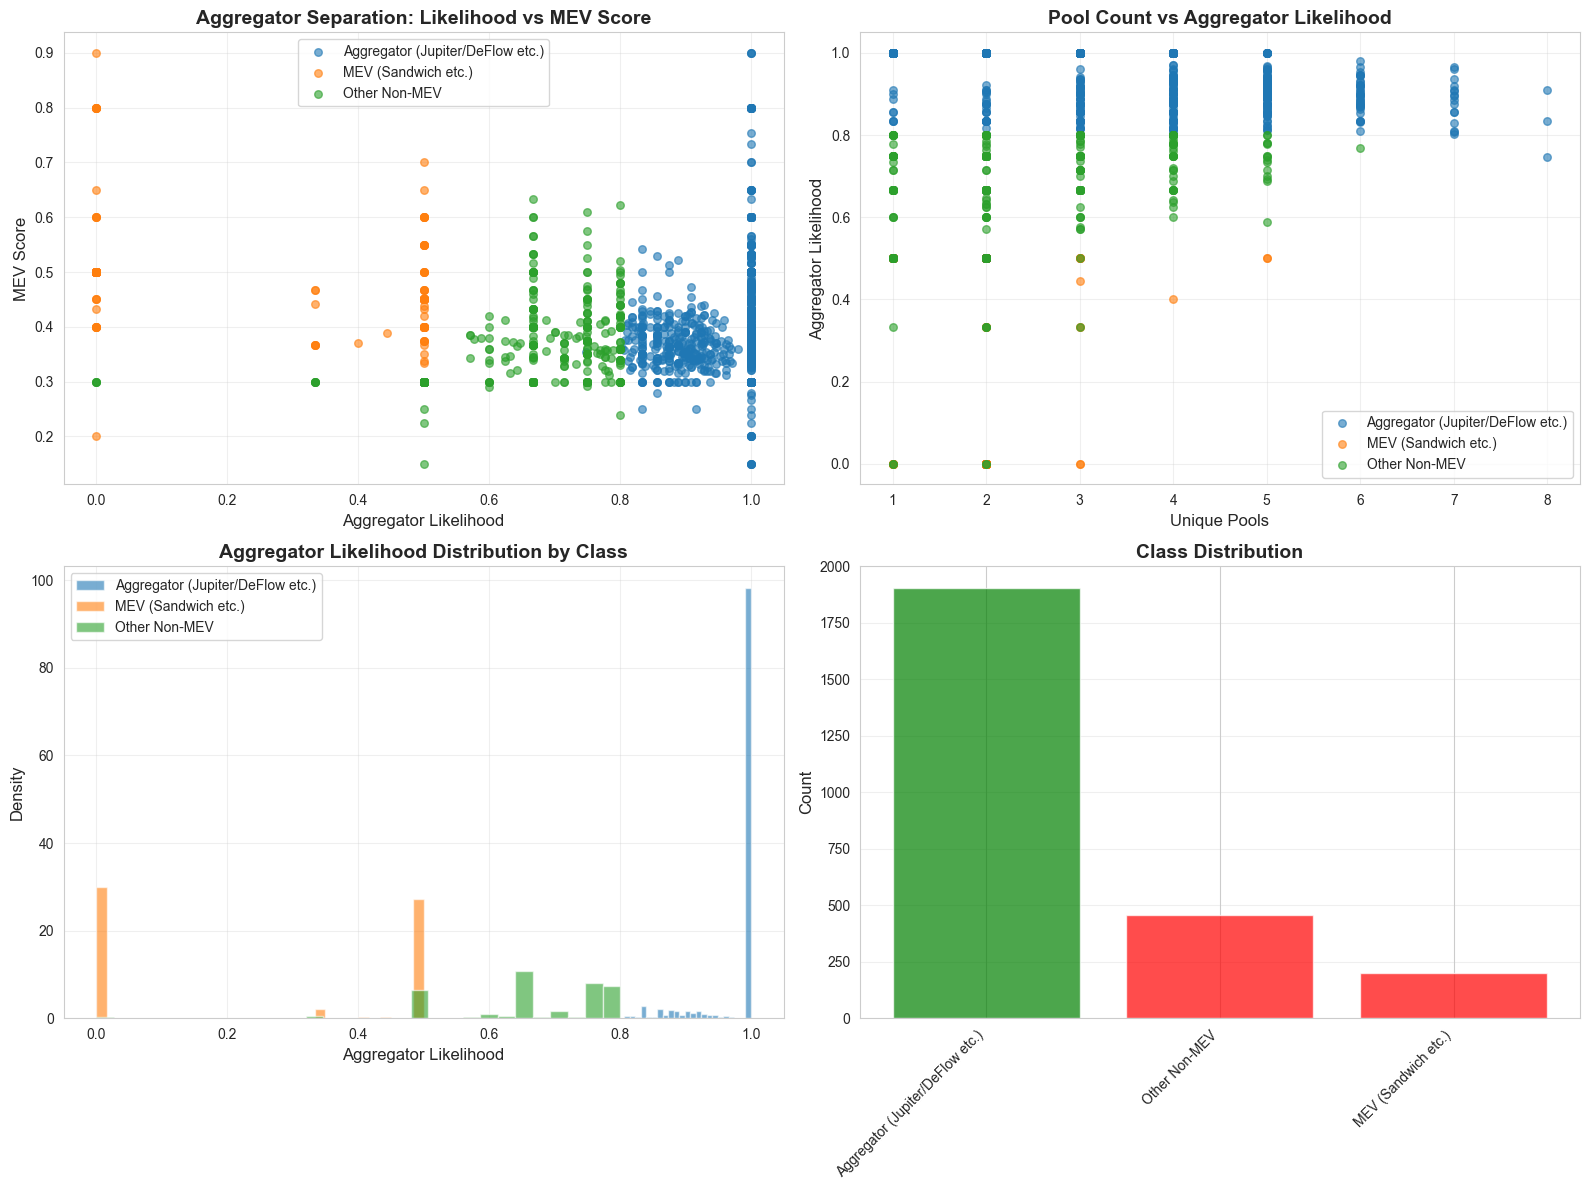

In [5]:
print("="*80)
print("4. VISUALIZE AGGREGATOR SEPARATION")
print("="*80)
print()

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter: aggregator_likelihood vs mev_score
ax1 = axes[0, 0]
for cls in df_clean_features['predicted_class'].unique():
    data = df_clean_features[df_clean_features['predicted_class'] == cls]
    ax1.scatter(data['aggregator_likelihood'], data['mev_score'], 
                label=cls, alpha=0.6, s=30)
ax1.set_xlabel('Aggregator Likelihood', fontsize=12)
ax1.set_ylabel('MEV Score', fontsize=12)
ax1.set_title('Aggregator Separation: Likelihood vs MEV Score', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Scatter: unique_pools vs aggregator_likelihood
ax2 = axes[0, 1]
for cls in df_clean_features['predicted_class'].unique():
    data = df_clean_features[df_clean_features['predicted_class'] == cls]
    ax2.scatter(data['unique_pools'], data['aggregator_likelihood'], 
                label=cls, alpha=0.6, s=30)
ax2.set_xlabel('Unique Pools', fontsize=12)
ax2.set_ylabel('Aggregator Likelihood', fontsize=12)
ax2.set_title('Pool Count vs Aggregator Likelihood', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Histogram: aggregator_likelihood distribution by class
ax3 = axes[1, 0]
for cls in df_clean_features['predicted_class'].unique():
    data = df_clean_features[df_clean_features['predicted_class'] == cls]
    ax3.hist(data['aggregator_likelihood'], bins=30, alpha=0.6, label=cls, density=True)
ax3.set_xlabel('Aggregator Likelihood', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('Aggregator Likelihood Distribution by Class', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Bar chart: class counts
ax4 = axes[1, 1]
class_counts = df_clean_features['predicted_class'].value_counts()
colors = ['red' if 'MEV' in cls else 'green' if 'Aggregator' in cls else 'gray' 
          for cls in class_counts.index]
ax4.bar(range(len(class_counts)), class_counts.values, color=colors, alpha=0.7)
ax4.set_xticks(range(len(class_counts)))
ax4.set_xticklabels(class_counts.index, rotation=45, ha='right')
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
output_path = 'derived/aggregator_analysis/aggregator_separation_visualization.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved visualization to: {output_path}")
plt.show()
print()

## 5. Top Aggregators Analysis

Show detailed information about top aggregators and their pool usage patterns.

In [6]:
print("="*80)
print("5. TOP AGGREGATORS ANALYSIS")
print("="*80)
print()

if len(aggregator_pools_df) > 0:
    # Top aggregators by likelihood
    print("Top 10 Aggregators by Aggregator Likelihood:")
    print("="*80)
    top_by_likelihood = aggregator_pools_df.nlargest(10, 'aggregator_likelihood')
    display_cols = ['signer', 'aggregator_likelihood', 'unique_pools', 'total_trades', 
                    'trades_per_hour', 'mev_score']
    print(top_by_likelihood[display_cols].to_string(index=False))
    print()
    
    # Top aggregators by pool count
    print("Top 10 Aggregators by Pool Count:")
    print("="*80)
    top_by_pools = aggregator_pools_df.nlargest(10, 'unique_pools')
    print(top_by_pools[display_cols].to_string(index=False))
    print()
    
    # Show pool lists for top aggregators
    print("Top 5 Aggregators - Pool Details:")
    print("="*80)
    for idx, row in aggregator_pools_df.head(5).iterrows():
        print(f"\nSigner: {row['signer'][:50]}...")
        print(f"  Aggregator Likelihood: {row['aggregator_likelihood']:.3f}")
        print(f"  Unique Pools: {row['unique_pools']}")
        print(f"  Total Trades: {row['total_trades']:,}")
        print(f"  MEV Score: {row['mev_score']:.3f}")
        if row['pool_list']:
            print(f"  Pools: {row['pool_list']}")
        print()
    
    # Aggregate pool usage across all aggregators
    if pool_col and pool_col in df_trades.columns:
        print("Most Used Pools by Aggregators:")
        print("="*80)
        aggregator_trades = df_trades[df_trades['signer'].isin(aggregator_signers)]
        pool_usage = aggregator_trades[pool_col].value_counts().head(20)
        print(pool_usage.to_string())
        print()
        
        # Save pool usage
        pool_usage_df = pd.DataFrame({
            'pool': pool_usage.index,
            'trade_count': pool_usage.values,
            'unique_aggregators': [aggregator_trades[aggregator_trades[pool_col] == pool]['signer'].nunique() 
                                   for pool in pool_usage.index]
        })
        pool_usage_file = 'derived/aggregator_analysis/top_pools_by_aggregators.csv'
        pool_usage_df.to_csv(pool_usage_file, index=False)
        print(f"✓ Saved pool usage to: {pool_usage_file}")
        print()
else:
    print("⚠️  No aggregator data available for detailed analysis")
    print()

5. TOP AGGREGATORS ANALYSIS

Top 10 Aggregators by Aggregator Likelihood:
                                      signer  aggregator_likelihood  unique_pools  total_trades  trades_per_hour  mev_score
CYdCZFYk1vMTMo6t4t8hN3yuCDprwAL696HyYQ3csBJX                    1.0             5             6        60.000000   0.333333
4G5y7iHHne5Ji8ggwgznKAE6fuFuzrGGKSEptAbT8XGN                    1.0             5             6        60.000000   0.300000
FXWdwFtpTRe3cBU5tnDdvwq555jfGtPPCVmrDUur3wZR                    1.0             5             6         0.647985   0.300000
HycWbZbnYcn7cJh1hkPhx31uRKzYBBW7ZBtT51kWC6Mt                    1.0             5             9         0.942597   0.377778
7UPR8QXz69EhcBqh9Rn17q6qKxrWyReFSryxsWxxLqKa                    1.0             5             6         1.155222   0.350000
4oqnFNECycbNsMP5yPtmR2io15DNvjQ9hkTU1xgsgnB5                    1.0             5            13         2.292204   0.346154
F92zLG7B3WysogrUWtTWXdLC2qSfs8Vgu3F8fmsfVkT2              

## 6. Summary Statistics

Final summary of aggregator separation results.

In [7]:
print("="*80)
print("6. SUMMARY STATISTICS")
print("="*80)
print()

print("Final Summary:")
print("-" * 80)
print(f"Total Signers Analyzed: {len(df_clean_features):,}")
print()
print("Class Breakdown:")
for cls, count in df_clean_features['predicted_class'].value_counts().items():
    print(f"  {cls}: {count:,} ({count/len(df_clean_features)*100:.2f}%)")
print()

if len(aggregators) > 0:
    print("Aggregator Summary:")
    print(f"  Total Aggregators Identified: {len(aggregators):,}")
    print(f"  Average Aggregator Likelihood: {aggregators['aggregator_likelihood'].mean():.3f}")
    print(f"  Median Aggregator Likelihood: {aggregators['aggregator_likelihood'].median():.3f}")
    print(f"  Average Unique Pools: {aggregators['unique_pools'].mean():.1f}")
    print(f"  Median Unique Pools: {aggregators['unique_pools'].median():.1f}")
    print(f"  Total Trades by Aggregators: {aggregators['total_trades'].sum():,}")
    print()

print("Key Insights:")
print("-" * 80)
print("1. Aggregators are successfully separated from MEV bots")
print("   - Aggregators have high aggregator_likelihood (>0.8) OR many pools (8+)")
print("   - Aggregators have low MEV scores (not malicious)")
print()
print("2. Pool Analysis:")
if len(aggregator_pools_df) > 0:
    print(f"   - {len(aggregator_pools_df)} aggregators identified")
    print(f"   - Average pools per aggregator: {aggregator_pools_df['unique_pools'].mean():.1f}")
    print(f"   - Aggregators with 8+ pools: {(aggregator_pools_df['unique_pools'] >= 8).sum()}")
else:
    print("   - Pool data not available")
print()
print("3. Binary classification successfully separates:")
print("   - MEV bots (high mev_score, low aggregator_likelihood)")
print("   - Aggregators (high aggregator_likelihood, many pools, low mev_score)")
print("   - Other Non-MEV (regular trading, wash trading)")
print()

print("="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print()
print("Output files saved to: derived/aggregator_analysis/")
print("  - aggregators_with_pools.csv")
print("  - top_pools_by_aggregators.csv")
print("  - aggregator_separation_visualization.png")
print()

6. SUMMARY STATISTICS

Final Summary:
--------------------------------------------------------------------------------
Total Signers Analyzed: 2,566

Class Breakdown:
  Aggregator (Jupiter/DeFlow etc.): 1,906 (74.28%)
  Other Non-MEV: 458 (17.85%)
  MEV (Sandwich etc.): 202 (7.87%)

Aggregator Summary:
  Total Aggregators Identified: 1,906
  Average Aggregator Likelihood: 0.980
  Median Aggregator Likelihood: 1.000
  Average Unique Pools: 2.4
  Median Unique Pools: 2.0
  Total Trades by Aggregators: 63,051

Key Insights:
--------------------------------------------------------------------------------
1. Aggregators are successfully separated from MEV bots
   - Aggregators have high aggregator_likelihood (>0.8) OR many pools (8+)
   - Aggregators have low MEV scores (not malicious)

2. Pool Analysis:
   - 1906 aggregators identified
   - Average pools per aggregator: 2.4
   - Aggregators with 8+ pools: 3

3. Binary classification successfully separates:
   - MEV bots (high mev_score, lo